In [101]:
import git

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM



In [2]:
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Processing Italy data

In [3]:
italy_df = pd.read_csv(f"{homedir}/data/international/italy/covid/dpc-covid19-ita-regioni.csv")
italy_df.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'note_it', 'note_en'],
      dtype='object')

In [4]:
italian_labels = italy_df.columns.tolist()
english_labels = ['Date', 'County', 'Regional Code', 'Region', 'Latitude', 'Longitude', 'HospitalizedWithSymptoms',
                  'IntensiveCare', 'TotalHospitalized', 'HomeIsolation', 'TotalPositive', 
                  'TotalPositiveChange', 'NewPositive', 'DischargedHealed', 'Deaths', 'TotalCases', 'Tested', 'Note_IT', 'Note_ENG']

rename_column_labels = dict(zip(italian_labels, english_labels))

italy_df = italy_df.rename(columns= rename_column_labels)

In [5]:
populations = pd.read_csv(f"{homedir}/data/international/italy/demographics/region-populations.csv")
def get_population(region):
    p = populations[populations['Region'] == region]['Population'].values
    if len(p) >= 1:
        return p[0]
    else:
        return 4446220 #setting places with no population info to this because there is only 1

italy_df['Population'] = italy_df.apply(lambda row: get_population(row.Region), axis=1)


def normalize(p):
    return (p-p.min())/(p.max()-p.min())

pop = italy_df['Population'].values #returns a numpy array
italy_df['PopulationScaled'] = normalize(pop)

lat = italy_df['Latitude'].values #returns a numpy array
italy_df['LatitudeScaled'] = normalize(lat)

long = italy_df['Longitude'].values #returns a numpy array
italy_df['LongitudeScaled'] = normalize(long)


In [6]:
#Emilia-Romagna has no population information
#italy_df[italy_df['Population'] == 0

italy_df.loc[italy_df['Region'] == 'P.A. Trento', 'Regional Code'] = 21
set(italy_df['Regional Code'].tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [7]:
italy_df['TotalPositive'] = italy_df['TotalPositive'].astype(float)
italy_df['Deaths'] = italy_df['Deaths'].astype(float)

# Input Data

In [8]:
def piecewise_log(arr):
    arr[arr == 0] = 1
    return np.log(arr)

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
split_point = 37

inputs = []
targets = []
conditions = []

days = range(0, 47)


mins = []
maxs = []

mins_y = []
maxs_y = []

def minmax_scalar(x): 
    scaled_x = (x - min(x))/(max(x) - min(x))
    return scaled_x, min(x), max(x)

for i in range(1, 22):
    x = np.array(italy_df[italy_df['Regional Code'] == i]['TotalPositive'].tolist())
    scaled_x, minx, maxx = minmax_scalar(x)
    
    mins.append(minx)
    maxs.append(maxx)
    
    y = np.array([italy_df[italy_df['Regional Code'] == i]['Deaths'].tolist()]).transpose()
    
    scaled_y, miny, maxy = minmax_scalar(y)
    
    inputs.append(np.stack((scaled_x, days), axis = 1))
    targets.append(scaled_y)
    
    p = italy_df[italy_df['Regional Code'] == i]['PopulationScaled'].values[0]
    lat = italy_df[italy_df['Regional Code'] == i]['LatitudeScaled'].values[0]
    long = italy_df[italy_df['Regional Code'] == i]['LongitudeScaled'].values[0]
    
    conditions.append(np.array([p]))

inputs = np.array(inputs)
targets = np.array(targets)
conditions = np.array(conditions)
    

split_point = 15
    
# train_inputs = inputs[:, :split_point]
# train_targets = targets[:, :split_point]

# test_inputs = inputs[:, split_point:]
# test_targets = targets[:, split_point:]

train_inputs = inputs[:split_point, :]
train_targets = targets[:split_point, :]

test_inputs = inputs[split_point:, :]
test_targets = targets[split_point:, :]

train_conditions = conditions[:split_point]
test_conditions = conditions[split_point:]

In [98]:
#aggregate_italy_df = pd.read_csv(f"{homedir}/data/international/italy/aggregate_italy.csv")    

# Build and Run Model

In [99]:
from cond_rnn import ConditionalRNN

class MySimpleModel(tf.keras.Model):
    def __init__(self):
        super(MySimpleModel, self).__init__() #allows you to inherit methods from tf.keras.Model I think
        self.cond = ConditionalRNN(20, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond2 = ConditionalRNN(12, cell='LSTM', dtype=tf.float32, return_sequences=True)
        self.cond3 = ConditionalRNN(1, cell='LSTM', dtype=tf.float32, return_sequences=True)
    
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs, **kwargs):
        x, cond = inputs
        o = self.cond([x, cond])
        o = self.cond2([o, cond])
        o = self.cond3([o, cond])
        o = self.out(o)
        return o

model = MySimpleModel()

# Define (real) data.


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.call([train_inputs, train_conditions])
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(x=[train_inputs, train_conditions], y=train_targets,
          validation_data=([test_inputs, test_conditions], test_targets),
          epochs=40)

print('Evaluating model:')
model.evaluate([test_inputs, test_conditions], test_targets)



#learning rate
#more samples
#more layers or cells
#more windows
#map curve 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended

0.007104864344000816

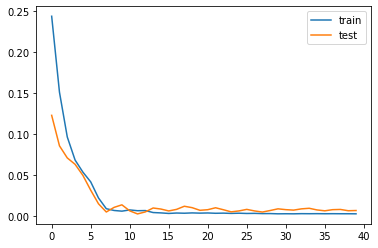

In [100]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [458]:
min(history.history['val_loss'])

1.6257113218307495

Prediction:


IndexError: index 15 is out of bounds for axis 0 with size 15

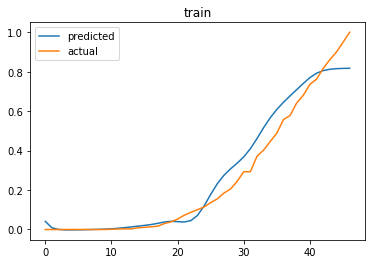

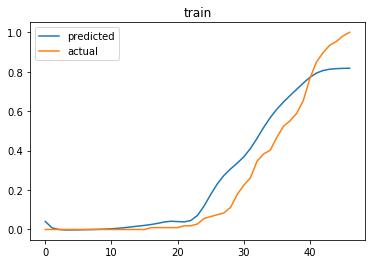

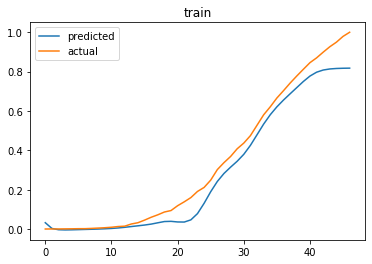

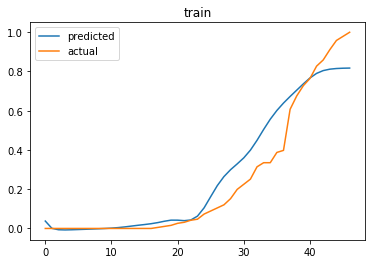

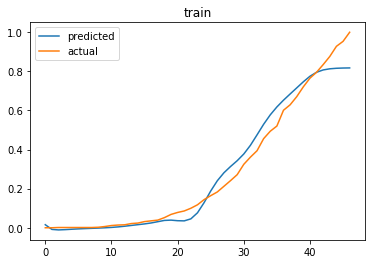

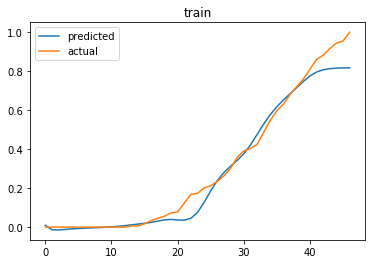

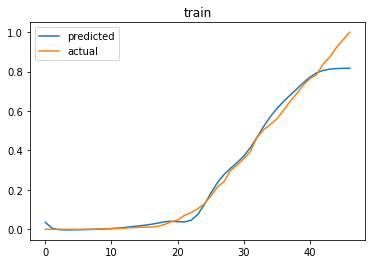

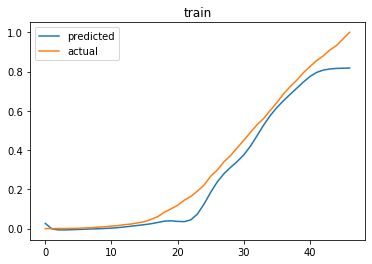

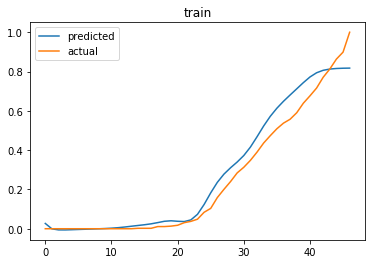

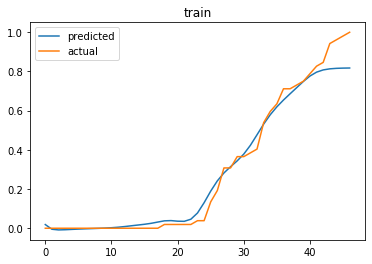

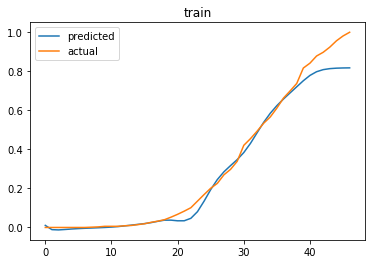

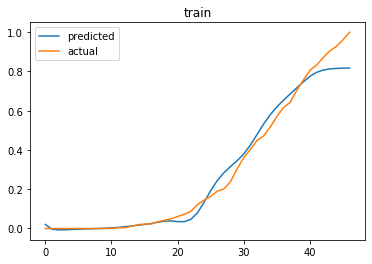

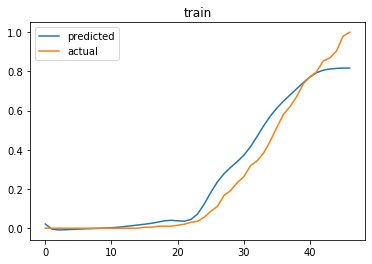

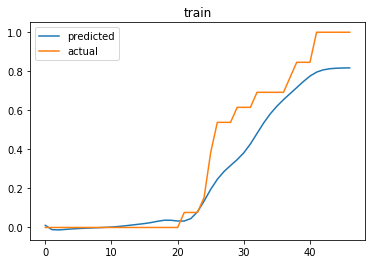

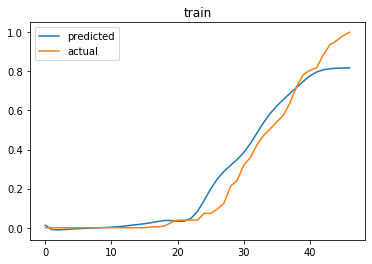

<Figure size 432x288 with 0 Axes>

In [94]:
print('Prediction:')
y_predict = model.predict([train_inputs, train_conditions])

for i in range(0, 21):
    plt.plot(y_predict[i], label = 'predicted')
    plt.plot(train_targets[i][:, 0], label = 'actual')
    plt.legend()
    plt.title('train')
    plt.figure()

Prediction:


IndexError: index 6 is out of bounds for axis 0 with size 6

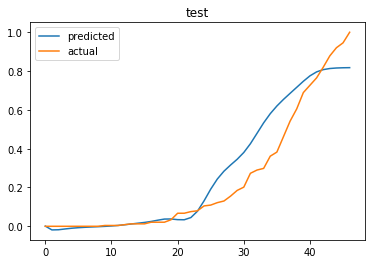

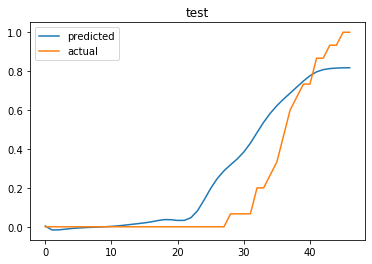

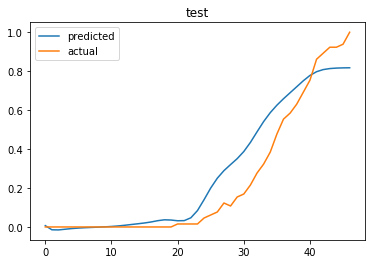

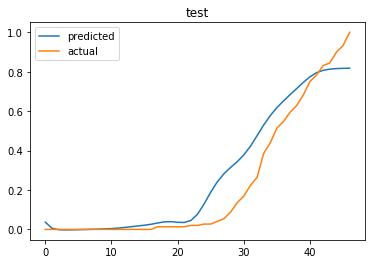

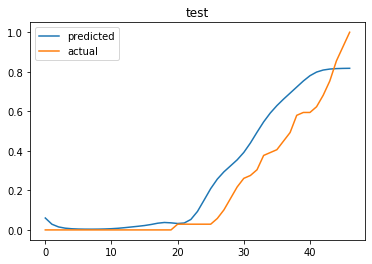

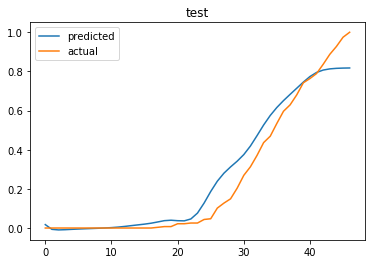

<Figure size 432x288 with 0 Axes>

In [92]:
print('Prediction:')
y_predict = model.predict([test_inputs, test_conditions])

for i in range(0, 21):
    plt.plot(y_predict[i], label = 'predicted')
    plt.plot(test_targets[i][:, 0], label = 'actual')
    plt.legend()
    plt.title('test')
    plt.figure()

In [321]:
np.shape(test_conditions)

(20, 3)